# Multiclass Text classification [link](https://www.tensorflow.org/tutorials/keras/text_classification)

In [1]:
import matplotlib.pyplot as plt
import os
import re
import shutil
import string
import tensorflow as tf
import numpy as np

from tensorflow.keras import layers
from tensorflow.keras import losses
# tf.debugging.set_log_device_placement(True) # to see which operation usees GPU

In [2]:
# Downlaoding the dataset
url = "https://storage.googleapis.com/download.tensorflow.org/data/stack_overflow_16k.tar.gz"

os.chdir('3-text-classifcation-dataset')
dataset = tf.keras.utils.get_file("stack_overflow_16k", url,
                                    untar=True, cache_dir='.',
                                    cache_subdir='')

In [3]:
# spliting train and test
BATCH_SIZE = 32
SEED = 42

raw_train_ds = tf.keras.utils.text_dataset_from_directory(
    'train', 
    batch_size=BATCH_SIZE, 
    validation_split=0.2, 
    subset='training', 
    seed=SEED)

raw_val_ds = tf.keras.utils.text_dataset_from_directory(
    'train', 
    batch_size=BATCH_SIZE, 
    validation_split=0.2, 
    subset='validation', 
    seed=SEED)

raw_test_ds = tf.keras.utils.text_dataset_from_directory(
    'test', 
    batch_size=BATCH_SIZE)


Found 8000 files belonging to 4 classes.
Using 6400 files for training.


2023-02-20 02:47:58.036316: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-20 02:47:58.044459: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-20 02:47:58.044913: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-20 02:47:58.046038: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

Found 8000 files belonging to 4 classes.
Using 1600 files for validation.
Found 8000 files belonging to 4 classes.


In [4]:
# preparig traing data (converting it to one hot encoding)
MAX_FEATURE = 10000
MAX_LENTH = 250

def custom_standarization(input_data):
    lowercase = tf.strings.lower(input_data)
    stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')
    stripped_html = tf.strings.regex_replace(stripped_html, '\n', '')
    return tf.strings.regex_replace(stripped_html, # removing punctuation
                                  '[%s]' % re.escape(string.punctuation),
                                  '')
# x = next(iter(raw_train_ds)) # tupple (text->(batch), class)
# print(custom_standarization(x[0][0]))


# vectorization layer (convertinig text to one-hot-encoding)
vectorize_layer = layers.TextVectorization(
    standardize=custom_standarization,
    max_tokens=MAX_FEATURE, # the lenth of the one-hot vector
    output_mode='int',
    output_sequence_length=MAX_LENTH #the max number of tokens in the input sentence
    
)


def vectorize_text(text, label):
    '''
    this function will be mapped (applyed to the dataset) as a prameter
    '''
    tf.expand_dims(text, -1)
    return vectorize_layer(text), label

# Initializing the vocabulary of the TextVectorizaion layer
train_text = raw_train_ds.map(lambda x, y: x)
vectorize_layer.adapt(train_text)


# Applying the vectorization
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

In [5]:
x = next(iter(raw_train_ds)) # tupple (text->(batch), class)
print(x[1][0].numpy())

1


In [24]:
# vectorize layer information

print("1287 ---> ",vectorize_layer.get_vocabulary()[1287])
print(" 313 ---> ",vectorize_layer.get_vocabulary()[313])
print('Vocabulary size: {}'.format(len(vectorize_layer.get_vocabulary())))

1287 --->  scissors
 313 --->  source
Vocabulary size: 10000


### Configure the dataset for performance

These are two important methods you should use when loading data to make sure that I/O does not become blocking.

`.cache()` keeps data in memory after it's loaded off disk. This will ensure the dataset does not become a bottleneck while training your model. If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache, which is more efficient to read than many small files.

`.prefetch()` overlaps data preprocessing and model execution while training. 

You can learn more about both methods, as well as how to cache data to disk in the [data performance guide](https://www.tensorflow.org/guide/data_performance)

In [6]:
AUTOTUNE = tf.data.AUTOTUNE


train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [7]:
# The model
EMBEDDING_DIM = 16

model = tf.keras.Sequential([
    layers.Embedding(MAX_FEATURE +1, EMBEDDING_DIM), # 10000 x 16 (batch, sequence, embedding)
    layers.Dropout(0.2),
    layers.GlobalAveragePooling1D(), # I thing average over embedding of the sqeunce(250 tokens)
    layers.Dropout(0.2), 
    layers.Dense(4) # 4 classes
    
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 16)          160016    
                                                                 
 dropout (Dropout)           (None, None, 16)          0         
                                                                 
 global_average_pooling1d (G  (None, 16)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 dense (Dense)               (None, 4)                 68        
                                                                 
Total params: 160,084
Trainable params: 160,084
Non-trainable params: 0
__________________________________________________

In [8]:
model.compile(
    optimizer='adam',
    metrics=['accuracy'],
    loss = tf.losses.SparseCategoricalCrossentropy(from_logits=True) # sparse means the classes not vecotrs
    # i.e [0, 0, 1, 0] insted they a number i.e: 2
)

In [9]:
# Training
EPOCHS = 10
history = model.fit(train_ds,
                   validation_data = val_ds,
                   epochs = EPOCHS)

Epoch 1/10
200/200 [==============================] - 2s 5ms/step - loss: 1.3790 - accuracy: 0.3633 - val_loss: 1.3674 - val_accuracy: 0.5381
Epoch 2/10
200/200 [==============================] - 1s 3ms/step - loss: 1.3495 - accuracy: 0.4691 - val_loss: 1.3278 - val_accuracy: 0.5319
Epoch 3/10
200/200 [==============================] - 1s 3ms/step - loss: 1.3001 - accuracy: 0.5402 - val_loss: 1.2697 - val_accuracy: 0.5938
Epoch 4/10
200/200 [==============================] - 1s 3ms/step - loss: 1.2338 - accuracy: 0.5850 - val_loss: 1.1986 - val_accuracy: 0.6306
Epoch 5/10
200/200 [==============================] - 1s 4ms/step - loss: 1.1583 - accuracy: 0.6292 - val_loss: 1.1247 - val_accuracy: 0.6656
Epoch 6/10
200/200 [==============================] - 1s 4ms/step - loss: 1.0862 - accuracy: 0.6684 - val_loss: 1.0552 - val_accuracy: 0.6881
Epoch 7/10
200/200 [==============================] - 1s 3ms/step - loss: 1.0162 - accuracy: 0.6973 - val_loss: 0.9914 - val_accuracy: 0.7094
Epoch 

In [10]:
# evaluating the model
loss, accuracy = model.evaluate(test_ds, verbose=2)

250/250 - 1s - loss: 0.8733 - accuracy: 0.7305 - 704ms/epoch - 3ms/step


In [11]:
print(history.history.keys())
print(len(history.history['val_accuracy']))

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])
10


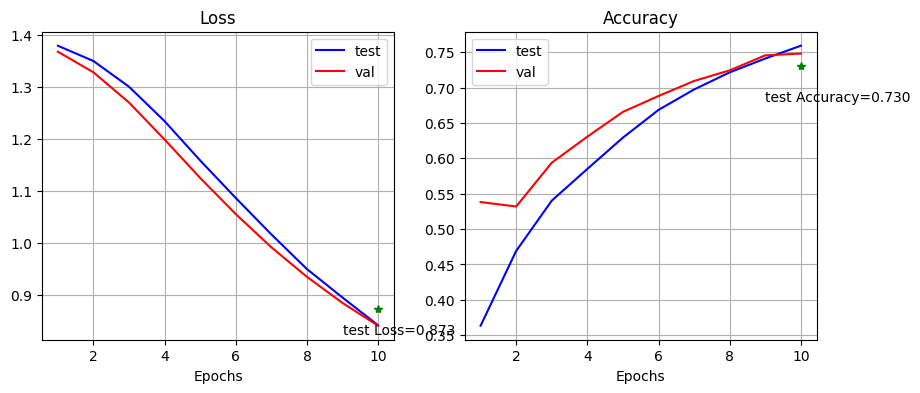

In [13]:
def plot_test_val(ax, title, test, val, test_point):
    x = np.arange(1, len(test) +1, 1)
    ax.plot(x, test, label='test', color='b')
    ax.plot(x, val, label='val', color='r')
    ax.plot([len(test)], [test_point], 'g*')
    ax.annotate(f"test {title}={test_point:.3f}", xy=(len(test), test_point), xytext=(len(test)-1, test_point-.05))
    ax.set_xlabel('Epochs')
    ax.legend()
    ax.set_title(title)
    ax.grid()
    
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
plot_test_val(ax1, 'Loss', history.history['loss'], history.history['val_loss'], loss)
plot_test_val(ax2, 'Accuracy', history.history['accuracy'], history.history['val_accuracy'], accuracy)

plt.show()


In [14]:
# making model ready for production
prediction_model = tf.keras.Sequential([
    vectorize_layer, 
    model, 
    layers.Softmax()
])

prediction_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, 250)              0         
 torization)                                                     
                                                                 
 sequential (Sequential)     (None, 4)                 160084    
                                                                 
 softmax (Softmax)           (None, 4)                 0         
                                                                 
Total params: 160,084
Trainable params: 160,084
Non-trainable params: 0
_________________________________________________________________


In [23]:
test_data = [
    "maxdegreeofparallelism not limiting the number of parallel tasks i am creating a number of threads and want to execute only n at a time. but i have a problem that when the code is executed it starts all threads at once...for (int i = 0; i &lt; global.mylist.count - 1; i++).{.    thread thread = new thread(() =&gt;.    {.        debug.writeline(""start signal from thread"", thread.currentthread.name);.        var account = global.mylist[i];.        thread.sleep(5000);.        debug.writeline(""end signal from thread"", thread.currentthread.name);.    });.    thread.name = i.tostring();.    threads.add(thread);.}..var option = new paralleloptions().{.    maxdegreeofparallelism = convert.toint32(numthreads.value).};..var locker = new object();.parallel.foreach(threads, option, t =&gt;.{.    if (t.isalive == false).    {.        t.start();.    }.    var count = convert.toint32(t.name);.    interlocked.increment(ref count);.    lock (locker).    {.        debug.writeline(""number of active threads:"" + count);.        thread.sleep(10);.    }.    interlocked.decrement(ref count);.});"
,
    
]
print(prediction_model.predict(test_data))
print(raw_train_ds.class_names)

1/1 [==============================] - 0s 50ms/step
[[0.35860732 0.29748198 0.20033512 0.1435756 ]]
['csharp', 'java', 'javascript', 'python']
